# Case 2. Diabetic Retinopathy Analysis
Sanni Tolonen<br>
25.2.2018<br>
Cognitive Systems for Health Technology Applications, Spring 2018<br>
Helsinki Metropolia University of Applied Sciences

<h2>1. Objectives</h2><br>
The aim of this assignment is to learn to use convolutional neural networks to classify medical
images.

<h2> 2. Required libraries </h2>

In [45]:
# import libraries and functions

import numpy as np
import matplotlib.pyplot as plt 
import pickle
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import os
import time

<h2> 3. Data description and preprocessing </h2>

This dataset is a large set of high-resolution retina images taken under a variety of imaging conditions. 
A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4:

<ul>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR</li>
</ul>

The images come from different models and types of cameras, which can affect the visual appearance. Some images are shown as one would see the retina anatomically meaning macula on the left, optic nerve on the right for the right eye. Others are shown as one would see through a microscope condensing lens in example inverted, as one sees in a typical live eye exam. There are two ways to tell if an image is inverted:

It is inverted if the macula, the small dark central area, is slightly higher than the midline through the optic nerve. If the macula is lower than the midline of the optic nerve, it's not inverted.
If there is a notch on the side of the image (square, triangle, or circle) then it's not inverted. If there is no notch, it's inverted.

In [35]:
# dataset directories and labels files

train_dir = "../dataset2/train" 
validation_dir = "../dataset2/validation" 
test_dir = "../dataset2/test" 

#preprocessing function

def my_fun(x):
    r = x[:, :, 0]
    g = x[:, :, 1]
    b = x[:, :, 2]
    r = (r - np.mean(r))/(12.0*np.std(r))
    g = (g - np.mean(g))/(12.0*np.std(g))
    b = (b - np.mean(g))/(12.0*np.std(b))
    x[:, :, 0] = r
    x[:, :, 1] = g
    x[:, :, 2] = b
    x += 0.5
    return x

Dataset is splitted to train, validation and test sets. For preprocessing I used a function defined by Sakari Lukkarinen. 

<h2> 4. Modeling and compilation </h2>

In [36]:
# training parameters

batch_size = 32
epochs = 10
steps_per_epoch = 39 
validation_steps = 13
image_height = 150
image_width = 200 

# create datagenerators

train_datagen = ImageDataGenerator(preprocessing_function = my_fun)
validation_datagen = ImageDataGenerator(preprocessing_function = my_fun)
test_datagen = ImageDataGenerator(preprocessing_function = my_fun)

# generator for train dataset

print('Training dataset.')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# generator for validation dataset

print('Validation dataset.')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# generator for test dataset

print('Test dataset.')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')



Training dataset.
Found 1928 images belonging to 2 classes.
Validation dataset.
Found 1021 images belonging to 2 classes.
Test dataset.
Found 1013 images belonging to 2 classes.


<h2> 5. Training and validation </h2>

For starters, there is two Conv2D layers followed by one MaxPool2D layer. After two sets of these, there is two Conv2D layers and then two sets of two Conv2D layers with a Dropout layer for weight regularization to avoid overfitting. In the end there is  Flatten layer to flatten the input, a couple of Dense leyers and another Dropout layer.

In [37]:
# build the model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                        input_shape = (image_height, image_width, 3)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D((3, 3), strides=2))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D((3, 3), strides=2))

model.add(layers.Conv2D(96, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(96, (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D((3, 3), strides=2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))

model.add(layers.Conv2D(160, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(160, (3, 3), activation = 'relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(192, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(192, (3, 3), activation = 'relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# compile the model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])


# train the model

t1 = time.time()
h = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      verbose = 1,
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps)
t2 = time.time()

# store the elapsed time into history

h.history.update({'time_elapsed': t2 - t1})
print(' ')
print('Total elapsed time for training: {:.3f} minutes'.format((t2-t1)/60))
print(' ')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 148, 198, 32)      896       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 146, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 72, 97, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 70, 95, 64)        18496     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 68, 93, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 33, 46, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 31, 44, 96)        55392     
__________

NameError: name 'model_filename' is not defined

In [40]:
# Saves the model and history
model.save('case_2_run_1.h5')
pickle.dump(h.history, open('case_2_history_1.p', 'wb'))

In [41]:
print('Elapsed time {:.2f} hours.'.format((t2-t1)/3600))
print('Time per epoch {:.2f} minutes.'.format((t2-t1)/10/60))

Elapsed time 2.04 hours.
Time per epoch 12.22 minutes.


<h2> 6. Evaluation </h2>

Here the model created above is tested with the testing set. 

In [42]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

r = model.evaluate_generator(test_generator, steps = 21)

# loss and accuracy
r

Found 1013 images belonging to 2 classes.


[4.7011111917949862, 0.70833333333333337]

<h2> 7. Results and discussion </h2>

Training accuracy is under 0.75 the whole time. The final testing accuracy is 0.71. In the end of training the loss function is 4.77 which is really big. This means that the inconsistency between predicted value and actual label is large. The final testing loss function is 4.70. 

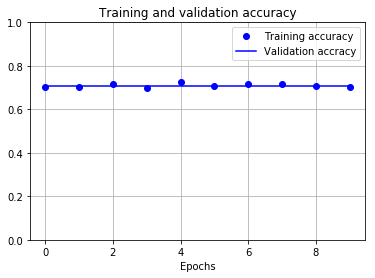

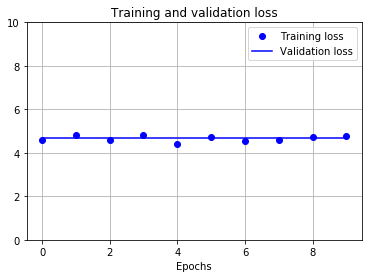

In [49]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accracy')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 10])
plt.xlabel('Epochs')
plt.grid()
plt.legend()  

plt.show()

<h2> 8. Conclusions </h2>

This Case 2 was a nice and definately interesting introduction to the convolutional neural networks. The objectives were in fact achieved because the convolutional neural network works. I think the difficulty level was ok, could have maybe been a little easier for my taste. I underestimated the time consuming of this assignment and that's why I have so few epochs. I'm aware that with more epochs, the results would have been better and more useful.

72% accuracy isn't that good for binary classification and it's not good enough for a medical classifier. Testing accuracy was at best 80%. The dataset seems fairly small for training a convolutional neural network and I think that with a larger dataset it would be possible to achieve better results.

I'm 99% sure that the problems I have in this network are caused by overfitting, but due to my lack of enthusiasm to do school work during this "spring break" I did not have the time to work with that more since I wanted to return the assignment in time. Unfortunately I still missed it. I did mess this assignment up pretty bad. This following night I will try leave my laptop running this same set with more epochs and return another version tomorrow, just for viewings.